In [1]:
%matplotlib inline

In [ ]:
# installing mplsoccer
# !pip install mplsoccer

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Pitch, Sbopen

In [6]:
parser = Sbopen()

df, related, freeze, tactics = parser.event(69301)

### Preparing data

In [22]:
# check the index for the first substitution

sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "England Women's"].iloc[0]["index"]

# create dataframe with sucessfull passes by England until the first substitution

mask_england = (df.type_name == 'Pass') & (df.team_name == "England Women's") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")

# taking necessary columns

df_pass = df.loc[mask_england, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]

# adjusting that only the surname of the player is presented

df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

### Calculating vertices size and location

In [23]:
scatter_df = pd.DataFrame()

for i, name in enumerate(df_pass['player_name'].unique()):

    passx = df_pass.loc[df_pass['player_name'] == name]['x'].to_numpy()
    recx = df_pass.loc[df_pass['pass_recipient_name'] == name]['end_x'].to_numpy()
    passy = df_pass.loc[df_pass['player_name'] == name]['y'].to_numpy()
    recy = df_pass.loc[df_pass['pass_recipient_name'] == name]['end_y'].to_numpy()

    scatter_df.at[i, 'player_name'] = name

    # making sure x and y location for each circle (player) is the avarage of passes and receptions

    scatter_df.at[i, 'x'] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, 'y'] = np.mean(np.concatenate([passy, recy]))

    # calculate the number of passes

    scatter_df.at[i, "no"] = df_pass.loc[df_pass['player_name'] == name].count().iloc[0]

# adjusting the size of the circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

### Calculating edges width

In [25]:
# couting passes between players

df_pass['pair_key'] = df_pass.apply(lambda x: '_'.join(sorted([x['player_name'], x['pass_recipient_name']])), axis=1)
lines_df = df_pass.groupby(['pair_key']).x.count().reset_index()
lines_df.rename({'x': 'pass_count'}, axis='columns', inplace=True)

# setting a treshold
lines_df = lines_df[lines_df['pass_count']>2]

### Plotting vertices

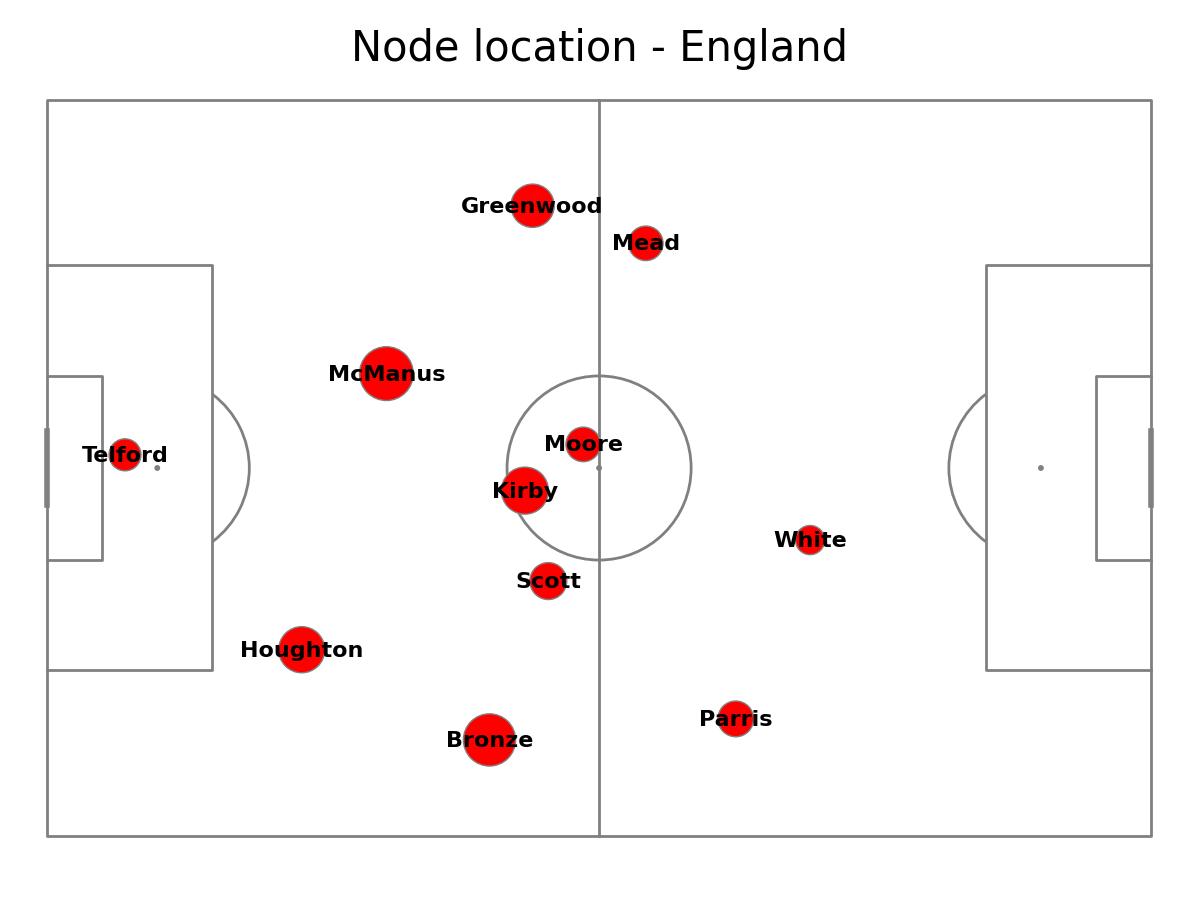

In [28]:
# drawing pitch

pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# scatter the location on the pich

pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax['pitch'], zorder=3)

# annotating player name

for i, row in scatter_df.iterrows():

    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight='bold', size=16, ax=ax['pitch'], zorder=4)

fig.suptitle("Node location - England", fontsize = 30)
plt.show()